In [1]:
import os
os.environ['MPLCONFIGDIR'] = os.getcwd()

import requests
import json
import re
import pyhf
import glob
from tqdm import tqdm_notebook as tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import array
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
# plt.style.use('atlas')

!rm -rf results
!mkdir results
!rm -rf Region*
!curl -sSL https://doi.org/10.17182/hepdata.89408.v1/r2 |tar -xzvf -

README.md
RegionA/BkgOnly.json
RegionA/patch.sbottom_1000_131_1.json
RegionA/patch.sbottom_1000_205_60.json
RegionA/patch.sbottom_1000_230_100.json
RegionA/patch.sbottom_1000_250_60.json
RegionA/patch.sbottom_1000_330_200.json
RegionA/patch.sbottom_1000_350_60.json
RegionA/patch.sbottom_1000_430_300.json
RegionA/patch.sbottom_1000_450_60.json
RegionA/patch.sbottom_1000_530_400.json
RegionA/patch.sbottom_1000_550_60.json
RegionA/patch.sbottom_1000_630_500.json
RegionA/patch.sbottom_1000_650_60.json
RegionA/patch.sbottom_1000_730_600.json
RegionA/patch.sbottom_1000_750_60.json
RegionA/patch.sbottom_1000_830_700.json
RegionA/patch.sbottom_1000_850_60.json
RegionA/patch.sbottom_1000_900_60.json
RegionA/patch.sbottom_1000_930_800.json
RegionA/patch.sbottom_1000_950_60.json
RegionA/patch.sbottom_1000_995_60.json
RegionA/patch.sbottom_1100_1050_60.json
RegionA/patch.sbottom_1100_1095_60.json
RegionA/patch.sbottom_1100_131_1.json
RegionA/patch.sbottom_1100_205_60.json
RegionA/patch.sbottom_110

In [2]:
def fit(region,patch):
    w = pyhf.Workspace(json.load(open('Region{}/BkgOnly.json'.format(region))))
    m = w.model(
        patches = [patch],
        modifier_settings={'normsys': {'interpcode': 'code4'},'histosys': {'interpcode': 'code4p'}},
    )
    d = w.data(m)
    o,e = pyhf.infer.hypotest(1.0,d,m, return_expected_set=True)

    return {
            'CLs_obs': o.tolist()[0],
            'CLs_exp': [ee.tolist()[0] for ee in e]
    }   

def func(data):
    filename = data['filename']
    region = data['region']
    m = re.compile("sbottom_(\d+)_(\d+)_(\d+)").search(filename).group(0)
    outname = 'results/region{}.result.{}.json'.format(region,m)
    d = fit(region,json.load(open(filename)))
    json.dump(d,open(outname,'w'))

In [3]:
import subprocess
from multiplex import main as multiplex_main
from interpolate import main as interpolate_main
from plotting import harvest_results
from collections import namedtuple
import json
import ROOT


def make_results():
    dataList = harvest_results(regions = ['A','C'])
    if not (dataList[0][1] or dataList[1][1]):
        return None,None

    d = {
        'figureOfMerit': 'CLsexp',
        'modelDef': 'msb,mn2,mn1',
        'ignoreTheory': True,
        'ignoreUL': True,
        'debug': False,
    }
    args = namedtuple('Args',d.keys())(**d)
    mux_data = multiplex_main(args,
        inputDataList =  dataList,

    ).to_dict(orient = "records")

    d = {
        'nominalLabel': 'Nominal',
        'xMin': None,
        'xMax': None,
        'yMin': None,
        'yMax': None,
        'smoothing': '0.1',
        'areaThreshold': 0,
        'xResolution': 100,
        'yResolution': 100,
        'xVariable': 'msb',
        'yVariable': 'mn2',
        'closedBands': False,
        'forbiddenFunction': 'x',
        'debug': False,
        'logX': False,
        'logY': False,
        'noSig': False,
        'interpolation': 'multiquadric',
        'interpolationEpsilon': 0,
        'level': 1.64485362695,
        'useROOT': False,
        'sigmax': 5,
        'useUpperLimit': False,
        'ignoreUncertainty': False,
        'fixedParamsFile': ''
    }
    args = namedtuple('Args',d.keys())(**d)
    r = interpolate_main(args,mux_data)
    return r,dataList

def make_plot(ax,**kwargs):
    ax.cla()
    ax.set_xlim(300,1700)
    ax.set_ylim(198,1700)
    r,x = make_results()
    if r is None:
        return

    if x[0][1] and kwargs.get('showPoints',False):
        y = np.asarray([[xx['msb'],xx['mn2']] for xx in x[0][1]])
        ax.scatter(y[:,0],y[:,1], s = 20, alpha = 0.2)
    if x[1][1] and kwargs.get('showPoints',False):
        y = np.asarray([[xx['msb'],xx['mn2']] for xx in x[1][1]])
        ax.scatter(y[:,0],y[:,1], s = 10, alpha = 0.2)

    x = np.asarray(array.array('d',r['Band_1s_0'].GetX()))
    y = np.asarray(array.array('d',r['Band_1s_0'].GetY()))
    
    explabel = r'Expected Limit ($\pm1\sigma$)'
    p = ax.add_patch(
        PolygonPatch(Polygon(np.stack([x,y]).T),alpha = 0.5, facecolor = kwargs.get('color','steelblue'),label = explabel),
    )


    x = np.asarray(array.array('d',r['Exp_0'].GetX()))
    y = np.asarray(array.array('d',r['Exp_0'].GetY()))
    ax.plot(x,y,  color = 'k', linestyle = 'dashed', alpha = 0.5)


    x = np.asarray(array.array('d',r['Obs_0'].GetX()))
    y = np.asarray(array.array('d',r['Obs_0'].GetY()))
    ax.plot(x,y,  color = 'maroon', linewidth = 2, linestyle = 'solid', alpha = 0.5, label = 'Observed Limit')
    apply_decorations(ax,kwargs['label'])
    
def apply_decorations(ax,label):
    ax.set_xlim(300,1700)
    ax.set_ylim(200,1700)
    # dictionaries to hold the styles for re-use
    text_fd = dict(ha='left', va='center')
    atlas_fd = dict(weight='bold', style='italic', size=24, **text_fd)
    internal_fd = dict(size=24, **text_fd)

    # actually drawing the text
    ax.text(0.05,0.9,'ATLAS', fontdict=atlas_fd, transform=ax.transAxes)
    ax.text(0.23,0.9,label, fontdict=internal_fd, transform=ax.transAxes)

    ax.text(
        0.05,
        0.8,
        "$\sqrt{s} = 13\ \mathrm{TeV}, 139\ \mathrm{fb}^{-1}$\n All limits at 95% CL",
        fontdict=text_fd,
        transform=ax.transAxes
    )
    ax.text(
        0.0,
        1.035,
        r"$\tilde{b}_1\tilde{b}_1$ production ; $\tilde{b}_1\to b \tilde{\chi}_2^0$; $m(\tilde{\chi}_1^0)$ = 60 GeV",
        fontdict=text_fd,
        transform=ax.transAxes
    )
    

    ax.text(
        350,
        750,
        r"Kinematically Forbidden $m(\tilde{\chi}_2^0)>m(\tilde{b}_1)$",
        rotation = 35.0,
        fontdict=dict(ha='left', va='center', size = 15, color = 'grey'),
    )
    ax.set_xlabel(r'$m(\tilde{b}_1)$ [GeV]',fontdict=dict(ha='right', va='center', size = 20))
    ax.set_ylabel(r'$m(\tilde{\chi}_2^0)$ [GeV]',fontdict=dict(ha='right', va='center', size = 20))
    
    ax.legend(loc = (0.05,0.6))
    ax.xaxis.set_label_coords(1.0, -0.1)
    ax.yaxis.set_label_coords(-0.15, 1.0)
    ax.plot([200,1400],[200,1400],color = 'grey', linestyle = 'dashdot')

Welcome to JupyROOT 6.22/00


<IPython.core.display.Javascript object>


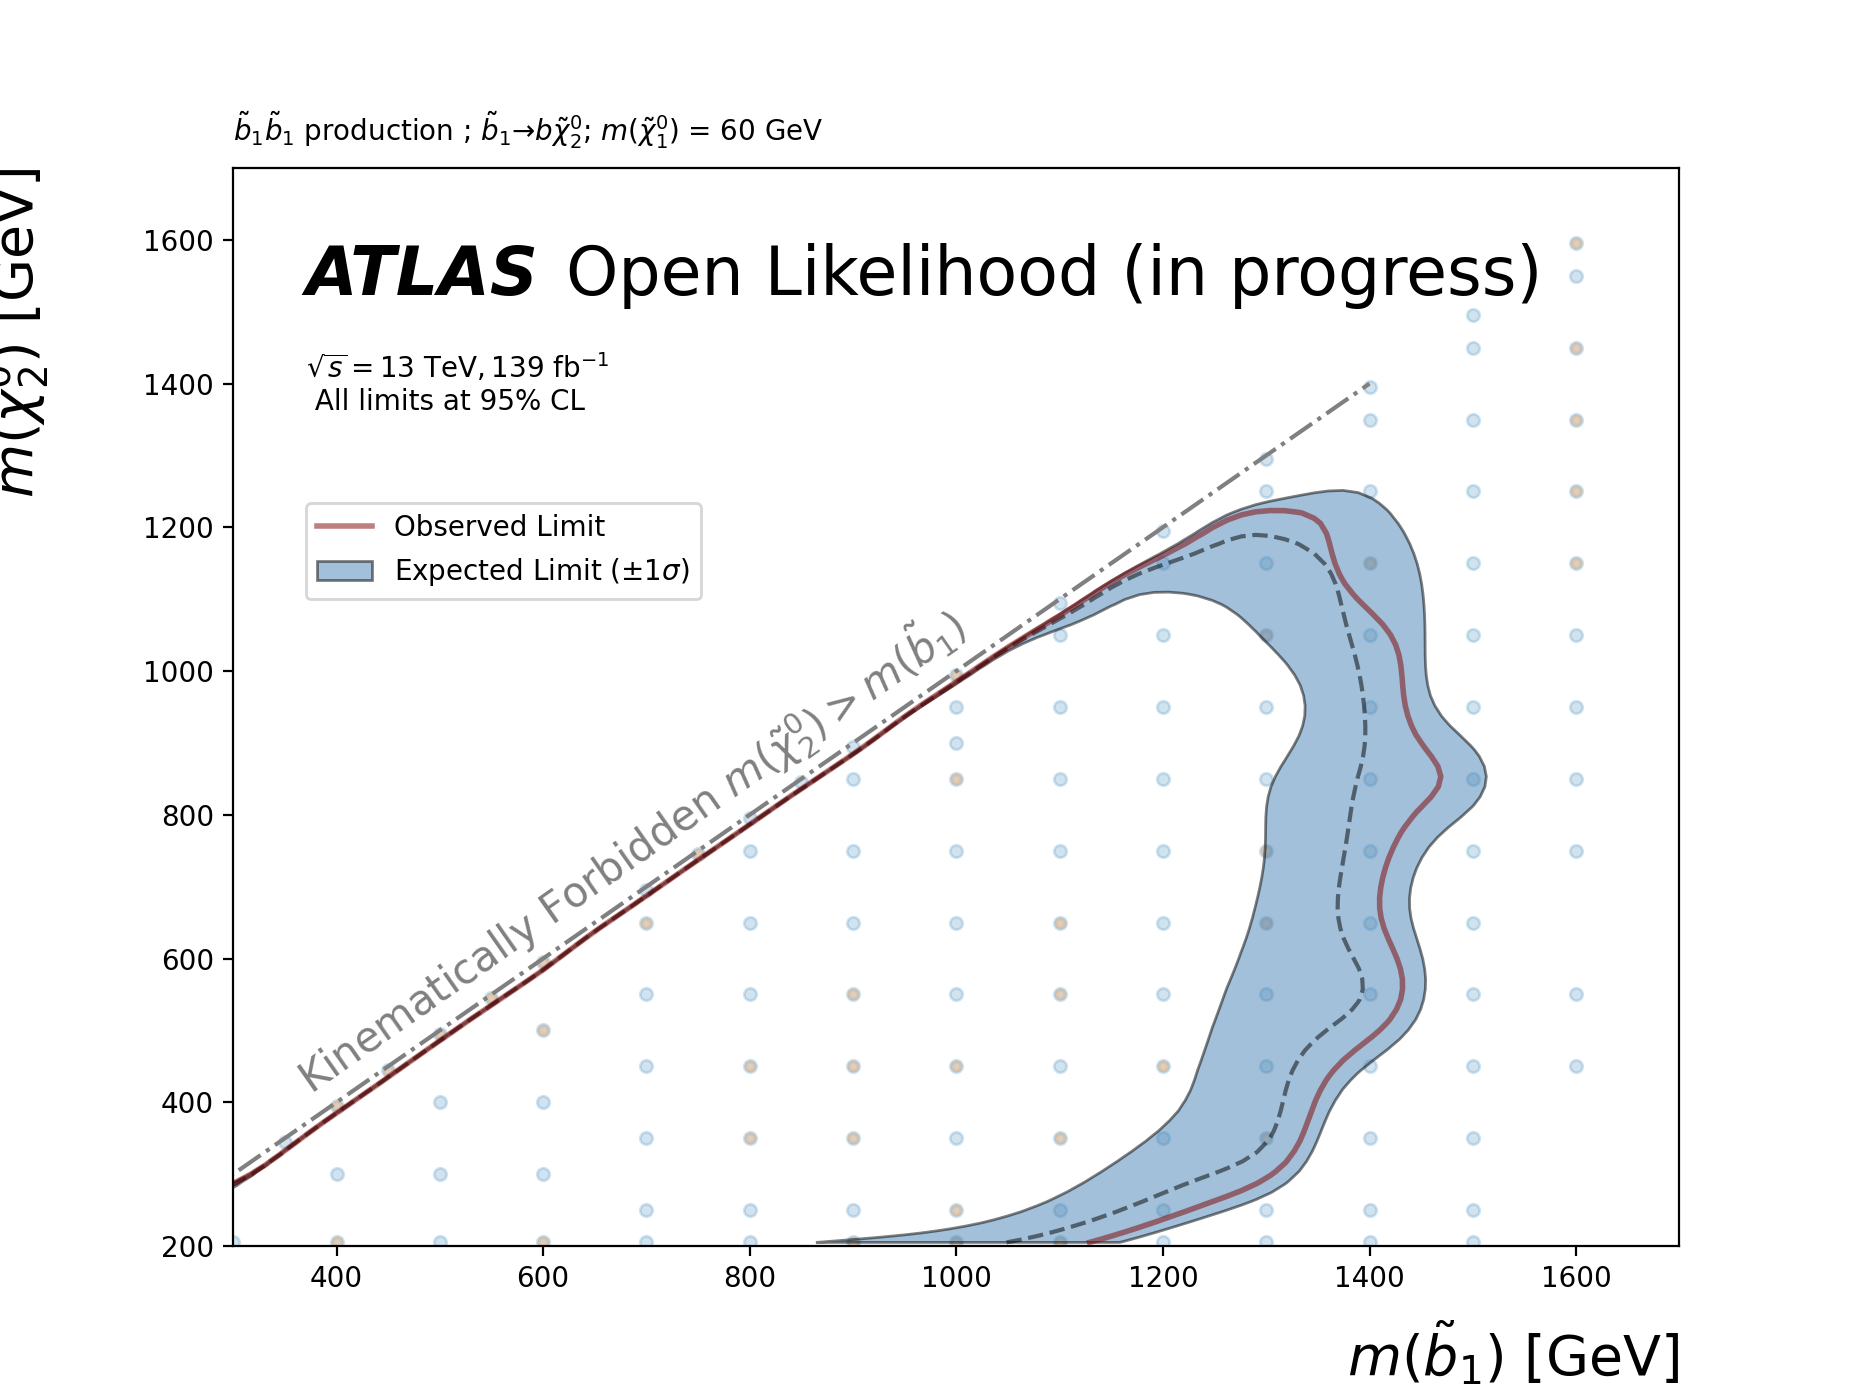

No handles with labels found to put in legend.


In [4]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
fig.set_size_inches(9.33,7)
apply_decorations(ax,label = 'Open Likelihood (in progress)')

In [ ]:
for x in glob.glob('results/*.json'):
    os.unlink(x)
cA = [{'region': 'A', 'filename': f} for f in glob.glob('RegionA/patch*_60.json')]
cC = [{'region': 'C', 'filename': f} for f in glob.glob('RegionC/patch*_60.json')]
configs = cA[:] + cC[:]

import time
import concurrent.futures
fig.canvas.draw()
for i,_ in enumerate(tqdm(map(func, configs),total = len(configs))):
    if i > 5 and i % 5 == 0:
        make_plot(ax,label = 'Open Likelihood (in progress)', color = 'steelblue', showPoints = True)
        fig.canvas.draw()
    time.sleep(.005)
make_plot(ax, label = 'Open Likelihood', color = 'gold', showPoints = False)
fig.canvas.draw()

<ipython-input-5-b6c957963ce2>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,_ in enumerate(tqdm(map(func, configs),total = len(configs))):


/usr/local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:255: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/interpolate.py:365: UserWarning: No contour levels were found within the data range.
  c = ax.contour(xi,yi,zi, [level])
/usr/local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:255: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/interpolate.py:365: UserWarning: No contour levels were found within the data range.
  c = ax.contour(xi,yi,zi, [level])
/usr/local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:255: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/interpolate.py:365: UserWarning: No contour levels were found within the data range.
  c = ax.contour(xi,yi,zi, [level])
/usr/local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:255: RuntimeWa